In [1]:
import pandas as pd

# URL of the dataset
url = "https://ourairports.com/countries/US/airports.hxl"

# Read the data into a DataFrame
df = pd.read_csv(url)

#remove that non useful row
df = df[df['id'] != '#meta +id']

# Save the entire DataFrame to a CSV file
df.to_csv('all_us_airports.csv', index=False)

# Display the first few rows of the DataFrame
df.count()


id                   30939
ident                30939
type                 30939
name                 30939
latitude_deg         30939
longitude_deg        30939
elevation_ft         28933
continent              110
country_name         30939
iso_country          30939
region_name          30939
iso_region           30939
local_region         30939
municipality         30881
scheduled_service    30939
gps_code             20315
iata_code             1971
local_code           21240
home_link             1163
wikipedia_link        2591
keywords              6157
score                30939
last_updated         30939
dtype: int64

In [2]:
#Task2 :- Filter Data to a Subset
# Load the cleaned data
df_cleaned = pd.read_csv('all_us_airports.csv')
# Filter large airports and select relevant columns
large_airports = df_cleaned[df_cleaned['type'] == 'large_airport'][['name', 'latitude_deg', 'longitude_deg', 'iata_code']]

# Save the filtered DataFrame to a new CSV file
large_airports.to_csv('large_us_airports.csv', index=False)
# count of rows
large_airports.count()
#view data
#large_airports.head()


name             67
latitude_deg     67
longitude_deg    67
iata_code        66
dtype: int64

In [3]:
import folium
from folium import plugins
import pandas as pd

# Load the data
df_large_airports = pd.read_csv('large_us_airports.csv')

# Create a base map
display_map = folium.Map(location=[df_large_airports['latitude_deg'].mean(), df_large_airports['longitude_deg'].mean()],
               zoom_start=4)

# Add airport markers to the map
for index, row in df_large_airports.iterrows():
    folium.Marker(
        location=[row['latitude_deg'], row['longitude_deg']],
        popup=f"{row['name']} ({row['iata_code']})",
        icon=folium.Icon(color='blue', icon='plane')
    ).add_to(display_map)

# Display the map directly in the Jupyter Notebook
display_map
    

In [4]:
pip install requests


Note: you may need to restart the kernel to use updated packages.


In [5]:
import requests
import time
import pandas as pd

# Function to make API call with a pause
def make_api_call(url, params=None):
    response = requests.get(url, params=params)
    time.sleep(2)  # pause it for the response
    return response.json()

# Set the OpenAQ API endpoint
api_url = "https://api.openaq.org/v2/measurements"

# Set parameters for the API call
params = {
    "date_from": "2023-06-06T00:00:00Z",
    "date_to": "2023-06-07T00:00:00Z",
    "parameter": "pm25",
    "parameterid":"2",
     "coordinates": "42.33143000,-83.04575000",
   "limit": 10000,
    #"sort": "desc",
    "radius": 7500
    #"order_by": "datetime"
}

# Make the API call
data = make_api_call(api_url, params=params)

# Convert the response to a DataFrame
df_pm25_data = pd.DataFrame(data['results'])
#df_pm25_data.count()
# Display the DataFrame
#print(df_pm25_data.head())
#df_pm25_data.entity.unique()
# Save the DataFrame to a CSV file
df_pm25_data.to_csv('pm25_data_detroit.csv', index=False)
df_pm25_data.count()

locationId     6290
location       6290
parameter      6290
value          6290
date           6290
unit           6290
coordinates    6290
country        6290
city              0
isMobile       6290
isAnalysis        0
entity         6290
sensorType     6290
dtype: int64

In [6]:
df_pm25_data['entity'].unique()

array(['Governmental Organization', 'Community Organization'],
      dtype=object)

In [7]:
import pandas as pd
import ast

# Load the previously obtained JSON data into a DataFrame
df = pd.read_csv('pm25_data_detroit.csv')

# Transformations
df['coordinates'] = df['coordinates'].apply(ast.literal_eval)  # Convert string to dictionary
df['sensor_lat'] = df['coordinates'].apply(lambda x: x['latitude'])
df['sensor_lon'] = df['coordinates'].apply(lambda x: x['longitude'])
# Transformations
df['date'] = df['date'].apply(ast.literal_eval)  # Convert string to dictionary
#df['date_local'] = df['date'].apply(lambda x: x['utc'])
df['date_local'] = df['date'].apply(lambda x: x['local'])
df['date_local'] = pd.to_datetime(df['date_local'], format='%Y-%m-%dT%H:%M:%S%z')
df['date_local'].head()
df.rename(columns = {'date_local':'local_time'}, inplace = True)
df.entity.unique()
df['manufacturer '] =df['entity']
df.rename(columns = {'manufacturer ':'manufacturer'}, inplace = True) 

In [8]:
# Now 'date_local' should be in datetime format
print(df['local_time'].head())

0   2023-06-06 20:00:00-04:00
1   2023-06-06 19:00:00-04:00
2   2023-06-06 18:00:00-04:00
3   2023-06-06 17:00:00-04:00
4   2023-06-06 16:00:00-04:00
Name: local_time, dtype: datetime64[ns, UTC-04:00]


In [9]:
df.count()

locationId      6290
location        6290
parameter       6290
value           6290
date            6290
unit            6290
coordinates     6290
country         6290
city               0
isMobile        6290
isAnalysis         0
entity          6290
sensorType      6290
sensor_lat      6290
sensor_lon      6290
local_time      6290
manufacturer    6290
dtype: int64

In [10]:
#df = df.drop(['date.utc', 'coordinates', 'date'], axis=1)

df = df[df['manufacturer'].isin(['Governmental Organization', 'Community Organization'])]
#df.entity.unique()# Filtering
df = df[['locationId', 'location', 'entity', 'parameter', 'value', 'local_time', 'sensor_lat', 'sensor_lon','manufacturer','sensorType']]


# Store the final DataFrame to a CSV file
df.to_csv('20230606_detroit_downtown_7_5km_aq.csv', index=False)

In [11]:
pip install geopy


Note: you may need to restart the kernel to use updated packages.


In [12]:
import math

radius = 7.5
density_area = math.pi * math.pow(radius, 2)
print(density_area)


176.71458676442586


In [13]:
import pandas as pd
from geopy.distance import geodesic

# Load Detroit data
df = pd.read_csv('20230606_detroit_downtown_7_5km_aq.csv')


# 1. Mean and median PM2.5 reading over all sensors
mean_pm25 = df['value'].mean()
median_pm25 = df['value'].median()

print(f"1. Mean PM2.5 reading: {mean_pm25:.2f}")
print(f"   Median PM2.5 reading: {median_pm25:.2f}")

# 2. Standard deviation
std_dev = df['value'].std()
print(f"2. Standard deviation: {std_dev:.2f}")

# 3. Location_id with the highest PM2.5
max_pm25_location = df.loc[df['value'].idxmax(), 'locationId']
max_pm25_reading = df['value'].max()
print(f"3. Location_id with the highest PM2.5: {max_pm25_location}")
print(f"   Highest PM2.5 reading: {max_pm25_reading:.2f}")


# 4. Ratio of Community Organization to Governmental Organization entity type
#entity_type_ratio = df['entity_type'].value_counts(normalize=True)
ratio_community_to_government = df[df['manufacturer'] == 'Community Organization'].shape[0] / df[df['manufacturer'] == 'Governmental Organization'].shape[0]
print(f"4. Ratio of Community Organization to Governmental Organization:")
print(ratio_community_to_government)

# 5. Unique sensor stations (locationId)
unique_sensor_stations = df['locationId'].nunique()
print(f"5. Unique sensor stations: {unique_sensor_stations}")

# 6. Station density per km
# Note: Assuming latitude and longitude columns are 'latitude' and 'longitude'
station_density_km=df['locationId'].nunique()/density_area
print(f"6. Station density per km: {station_density_km}")
#print(df[['locationid', 'station_density_km']].drop_duplicates())


# 7. Daily statistics for Community Organization and Government Organization sensors
daily_stats = df.groupby(['entity', 'local_time'])['value'].describe()
print(f"7. Daily statistics for Community Organization and Government Organization sensors:")
print(daily_stats)

# 8. Opinion of the differences in statistics
# Comment specifically about the mean and 75%
community_stats = df[df['entity'] == 'Community Organization']['value'].describe()
government_stats = df[df['entity'] == 'Governmental Organization']['value'].describe()

print(f"8. Opinion of the differences in statistics:")
print("   Community Organization Statistics:")
print(community_stats)
print("\n   Government Organization Statistics:")
print(government_stats)

1. Mean PM2.5 reading: 66.12
   Median PM2.5 reading: 37.10
2. Standard deviation: 216.36
3. Location_id with the highest PM2.5: 65949
   Highest PM2.5 reading: 1759.50
4. Ratio of Community Organization to Governmental Organization:
65.21052631578948
5. Unique sensor stations: 15
6. Station density per km: 0.08488263631567752
7. Daily statistics for Community Organization and Government Organization sensors:
                                                     count       mean  \
entity                    local_time                                    
Community Organization    2023-06-05 20:00:30-04:00    1.0  33.900000   
                          2023-06-05 20:00:33-04:00    1.0  26.800000   
                          2023-06-05 20:00:42-04:00    1.0  39.300000   
                          2023-06-05 20:00:43-04:00    1.0  22.400000   
                          2023-06-05 20:00:47-04:00    1.0  34.700000   
...                                                    ...        ...   
Gov

In [14]:
from IPython.display import IFrame
import folium

# Create a map centered around downtown Detroit
detroit_coordinates = [42.33143000, -83.04575000]
detroit_map = folium.Map(location=detroit_coordinates, zoom_start=12)

# Add a pin for downtown Detroit
folium.Marker(location=detroit_coordinates, popup='Downtown Detroit', icon=folium.Icon(color='blue', icon='university', prefix='fa')).add_to(detroit_map)

# Add pins for community sensors (green) with default info ("i") icon
community_sensors = df[df['manufacturer'] == 'Community Organization']
for index, row in community_sensors.iterrows():
    folium.Marker(location=[row['sensor_lat'], row['sensor_lon']], popup=row['locationId'], icon=folium.Icon(color='green', icon='info', prefix='fa')).add_to(detroit_map)

# Add pins for government sensors (red) with default asterisk ("*") icon
government_sensors = df[df['manufacturer'] == 'Governmental Organization']
for index, row in government_sensors.iterrows():
    folium.Marker(location=[row['sensor_lat'], row['sensor_lon']], popup=row['locationId'], icon=folium.Icon(color='red', icon='asterisk', prefix='fa')).add_to(detroit_map)

# Save the map as an HTML file
detroit_map.save('detroit_map.html')

# Display the map in the notebook using an IFrame
IFrame('detroit_map.html', width=700, height=500)


Compare and contrast these readings – make a comment about their differences.
we can directly say Governmental Organization has too high PM2.5 value compare to Community Organization 


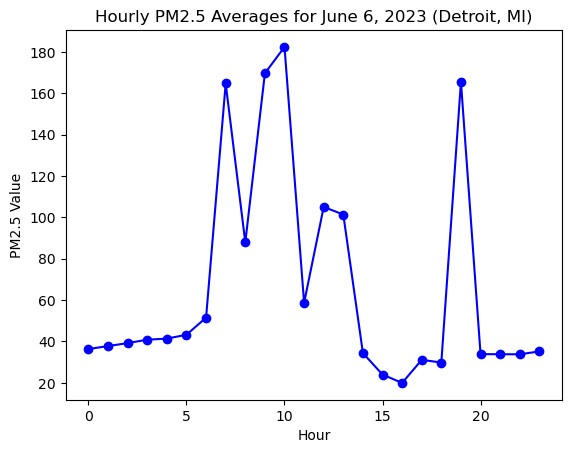

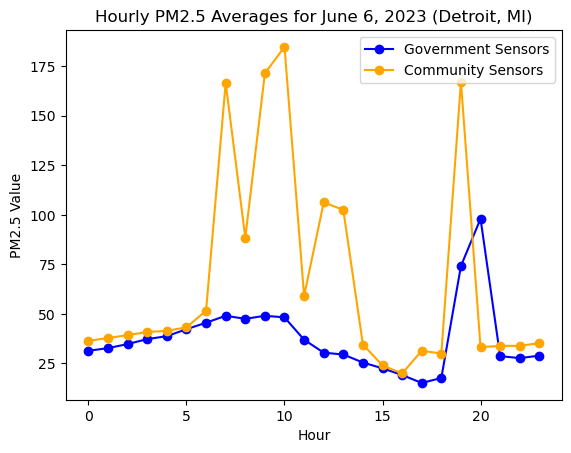

In [15]:
import matplotlib.pyplot as plt

# Convert 'local_time' to datetime
df['local_time'] = pd.to_datetime(df['local_time'])

# Create new column for hour
df['hour'] = df['local_time'].dt.hour

# 1. What are the average readings for each of the 6-hour blocks?
# 12am-6am
avg_12am_6am = df[(df['hour'] >= 0) & (df['hour'] < 6)]['value'].mean()

# 6am-noon
avg_6am_noon = df[(df['hour'] >= 6) & (df['hour'] < 12)]['value'].mean()

# noon-6pm
avg_noon_6pm = df[(df['hour'] >= 12) & (df['hour'] < 18)]['value'].mean()

# 6pm-11:59pm
avg_6pm_1159pm = df[(df['hour'] >= 18) & (df['hour'] < 24)]['value'].mean()

# 2. 
print('Compare and contrast these readings – make a comment about their differences.')
print('we can directly say Governmental Organization has too high PM2.5 value compare to Community Organization ')


# You can print the averages and make comments here.

# 3. Plot the hourly averages for the day using line plots
hourly_avg = df.groupby('hour')['value'].mean()
hourly_avg.plot(kind='line', marker='o', linestyle='-', color='b')
plt.title('Hourly PM2.5 Averages for June 6, 2023 (Detroit, MI)')
plt.xlabel('Hour')
plt.ylabel('PM2.5 Value')
plt.show()

# 4. Plot the hourly averages of the government and community sensors on the same plot
government_avg = df[df['manufacturer'] == 'Governmental Organization'].groupby('hour')['value'].mean()
community_avg = df[df['manufacturer'] == 'Community Organization'].groupby('hour')['value'].mean()

#plt.plot(hourly_avg.index, hourly_avg, label='All Sensors', marker='o', linestyle='-', color='b')
plt.plot(government_avg.index, government_avg, label='Government Sensors', marker='o', linestyle='-', color='blue')
plt.plot(community_avg.index, community_avg, label='Community Sensors', marker='o', linestyle='-', color='orange')

plt.title('Hourly PM2.5 Averages for June 6, 2023 (Detroit, MI)')
plt.xlabel('Hour')
plt.ylabel('PM2.5 Value')
plt.legend()
plt.show()


In [16]:
import numpy as np
import pandas as pd
from scipy.stats import normaltest, bartlett, ttest_ind

# 1. Build a dataset with 95 data points sampled from 100 random draws of data from the community sensors
community_data = df[df['manufacturer'] == 'Community Organization']['value']
government_data = df[df['manufacturer'] == 'Governmental Organization']['value']

# Create an empty DataFrame to store the 100 draws
draws_df = pd.DataFrame()

# Perform 100 draws
for _ in range(100):
    sample = community_data.sample(n=95, replace=True)
    draws_df[_] = sample.values
print(draws_df)
# Calculate the mean across draws
draws_mean = draws_df.mean(axis=1)

# 2. Descriptive statistics of your sample and the government data
sample_stats = draws_mean.describe()
government_stats = government_data.describe()

# 3. Compare and contrast, bring attention to the mean, 75%, and standard deviations.
print("Sample Statistics:")
print(sample_stats)
print("\nGovernment Data Statistics:")
print(government_stats)

print("""
Comparison:
Mean:
The mean in the sample statistics (66.42) is significantly higher than in the government data statistics (37.35). This suggests that, on average, the sample data tends to have higher values compared to the government data.

75th Percentile (Q3):
The 75th percentile in the sample statistics (73.10) is higher than in the government data statistics (45.40). This indicates that a significant portion of the sample has higher values in comparison.

Standard Deviation:
The standard deviation in the sample statistics (21.74) is higher than in the government data statistics (18.11). This implies that the values in the sample data are more spread out or varied compared to the government data.

Contrast:
Mean:
The mean in the government data is noticeably lower, indicating that, on average, the values are lower compared to the sample data.

75th Percentile (Q3):
The 75th percentile in the government data is substantially lower, suggesting that even at higher percentiles, the values in the government data are lower than in the sample data.

Standard Deviation:
The standard deviation in the government data is lower, indicating less variability in the values compared to the sample data.
""")


# 4. Run a test for normality on the two samples
_, p_value_community = normaltest(draws_mean)
_, p_value_government = normaltest(government_data)

print(f"\nNormality Test (p-values):")
print(f"Community Data: {p_value_community}")
print(f"Government Data: {p_value_government}")

# 5. Run a Barlett test for equal variances
_, p_value_bartlett = bartlett(draws_mean, government_data)

print(f"\nBartlett Test (p-value): {p_value_bartlett}")

# 6. Run the independent t-test
t_stat, p_value_ttest = ttest_ind(draws_mean, government_data, equal_var=(p_value_bartlett > 0.05))

print(f"\nIndependent t-test (p-value): {p_value_ttest}")


      0     1     2     3      4       5     6       7     8     9   ...  \
0   27.7  42.3  48.8  43.5   50.9    14.6  28.2    25.9  37.9  30.6  ...   
1   39.5  44.6  34.4  44.7   19.5    43.4  27.7    40.7  43.5  25.6  ...   
2   50.5  39.7  30.7  35.2   17.2    38.6  31.1    38.3  40.8  37.9  ...   
3   15.1  33.7  47.5   8.4   31.8  1725.1  42.9    45.7  36.6  14.3  ...   
4   35.4  27.1  46.7  10.2  130.4    33.0  39.2  1731.6   9.3  35.9  ...   
..   ...   ...   ...   ...    ...     ...   ...     ...   ...   ...  ...   
90  27.8  34.6  35.0  39.8   26.7    41.0  36.6    27.0  45.7  43.0  ...   
91  33.0  51.3  42.9  30.7   33.9    36.6  35.2    43.8  38.5  33.0  ...   
92  49.6  38.0  64.2  29.6   41.2    33.6  29.0    13.5  36.9  34.2  ...   
93  25.4  16.0  12.2  54.1   50.1    25.2  33.4    14.2  39.6  48.2  ...   
94  29.6  38.1  50.6  51.1   31.0    45.0  41.6    36.2  19.0  28.7  ...   

      90    91    92      93    94      95    96      97    98    99  
0   44.5  40.1  

In [17]:
pip install termcolor


Note: you may need to restart the kernel to use updated packages.


In [18]:
from IPython.display import HTML

text = "----------------------------------------     BONUS  ------------------------------------------   "
size = 80


# Format the HTML string with inline CSS for font size
html_string = f'<span style="font-size: {size}px;">{text}</span>'

# Display the HTML
display(HTML(html_string))


In [19]:
print("------------------------------------DETROIT DATA FOR COMPARISION------------------------------------")

import pandas as pd
import ast

# Load datasets
detroit_data = pd.read_csv("20230606_detroit_downtown_7_5km_aq.csv")

# Transformations
detroit_data['date'] = pd.to_datetime(detroit_data['local_time']).dt.date

# Filter data for June 6
detroit_june6 = detroit_data[detroit_data['date'] == pd.to_datetime('2023-06-06').date()]

# 1. Mean and median PM2.5 reading over all sensors
mean_pm25_detroit = detroit_june6['value'].mean()
median_pm25_detroit = detroit_june6['value'].median()

print(f"1. Mean PM2.5 reading (Detroit): {mean_pm25_detroit:.2f}")
print(f"   Median PM2.5 reading (Detroit): {median_pm25_detroit:.2f}")

# 2. Standard deviation
std_dev_detroit = detroit_june6['value'].std()
print(f"2. Standard deviation (Detroit): {std_dev_detroit:.2f}")

# 3. Location_id with the highest PM2.5
max_pm25_location_detroit = detroit_june6.loc[detroit_june6['value'].idxmax(), 'locationId']
max_pm25_reading_detroit = detroit_june6['value'].max()

print(f"3. Location_id with the highest PM2.5 (Detroit): {max_pm25_location_detroit}")
print(f"   Highest PM2.5 reading (Detroit): {max_pm25_reading_detroit:.2f}")

# 4. Ratio of Community Organization to Governmental Organization entity type
ratio_community_to_government_detroit = detroit_june6[detroit_june6['entity'] == 'Community Organization'].shape[0] / detroit_june6[detroit_june6['entity'] == 'Governmental Organization'].shape[0]
print(f"4. Ratio of Community Organization to Governmental Organization (Detroit): {ratio_community_to_government_detroit:.2f}")

# 5. Unique sensor stations (locationId)
unique_sensor_stations_detroit = detroit_june6['locationId'].nunique()
print(f"5. Unique sensor stations (Detroit): {unique_sensor_stations_detroit}")

# 6. Station density per km
station_density_km_detroit = detroit_june6['locationId'].nunique() / density_area
print(f"6. Station density per km (Detroit): {station_density_km_detroit:.2f}")

# 7. Daily statistics for Community Organization and Government Organization sensors
daily_stats_detroit = detroit_june6.groupby(['entity', 'local_time'])['value'].describe()
print(f"7. Daily statistics for Community Organization and Government Organization sensors:")
print(daily_stats_detroit)

# 8. Opinion of the differences in statistics
community_stats_detroit = detroit_june6[detroit_june6['entity'] == 'Community Organization']['value'].describe()
government_stats_detroit = detroit_june6[detroit_june6['entity'] == 'Governmental Organization']['value'].describe()

print(f"8. Opinion of the differences in statistics (Detroit):")
print("   Community Organization Statistics:")
print(community_stats_detroit)
print("\n   Government Organization Statistics:")
print(government_stats_detroit)


------------------------------------DETROIT DATA FOR COMPARISION------------------------------------
1. Mean PM2.5 reading (Detroit): 72.91
   Median PM2.5 reading (Detroit): 38.50
2. Standard deviation (Detroit): 237.58
3. Location_id with the highest PM2.5 (Detroit): 65949
   Highest PM2.5 reading (Detroit): 1759.50
4. Ratio of Community Organization to Governmental Organization (Detroit): 61.55
5. Unique sensor stations (Detroit): 15
6. Station density per km (Detroit): 0.08
7. Daily statistics for Community Organization and Government Organization sensors:
                                                     count       mean  \
entity                    local_time                                    
Community Organization    2023-06-06 00:00:35-04:00    1.0  30.400000   
                          2023-06-06 00:00:36-04:00    1.0  37.700000   
                          2023-06-06 00:00:44-04:00    1.0  44.100000   
                          2023-06-06 00:00:45-04:00    1.0  26.80000

In [20]:
print("------------------------------ Boston Logan International Airport  ------------------------------")
import requests
import time
import pandas as pd

# Function to make API call with a pause
def make_api_call(url, params=None):
    response = requests.get(url, params=params)
    time.sleep(2)  # pause it for the response
    return response.json()

# Set the OpenAQ API endpoint
api_url = "https://api.openaq.org/v2/measurements"

# Set parameters for the API call
params = {
    "date_from": "2023-06-01T00:00:00Z",
    "date_to": "2023-08-31T00:00:00Z",
    "parameter": "pm25",
    "parameterid": "2",
    "coordinates": "42.3643,-71.005203",  # Boston Logan International Airport coordinates
    "limit": 10000,
    "radius": 7500
}

# Make the API call
data = make_api_call(api_url, params=params)

# Check if the 'results' key is present
if 'results' in data:
    # Convert the response to a DataFrame
    df_pm25_data = pd.DataFrame(data['results'])
    print(df_pm25_data.count())
    
    # Save the DataFrame to a CSV file
    df_pm25_data.to_csv('pm25_data_boston.csv', index=False)
    #print(df_pm25_data.count())
else:
    print("No results found in the API response.")

##################################Analyze the data and answer the questions##################################


# Load datasets
detroit_data = pd.read_csv("20230606_detroit_downtown_7_5km_aq.csv")
df_boston = pd.read_csv("pm25_data_boston.csv")
# Transformations
# Transformations
df_boston['date'] = df_boston['date'].apply(ast.literal_eval)  # Convert string to dictionary
df_boston['local_time'] = df_boston['date'].apply(lambda x: x['local'])
df_boston['date'] = pd.to_datetime(df_boston['local_time'], format='%Y-%m-%dT%H:%M:%S%z')

detroit_data['date']=detroit_data['local_time']

#print(detroit_data['date'])

detroit_data['date'] = pd.to_datetime(detroit_data['date']).dt.date
df_boston['date'] = pd.to_datetime(df_boston['date']).dt.date

# Filter data for June 6
detroit_june6 = detroit_data[detroit_data['date'] == pd.to_datetime('2023-06-06').date()]
boston_june6 = df_boston[df_boston['date'] == pd.to_datetime('2023-06-06').date()]



# Filter data for June 6
#detroit_june6 = detroit_data[detroit_data['date'] == '2023-06-06']
#boston_june6 = boston_data[boston_data['date'] == '2023-06-06']

# 1. Mean and median PM2.5 reading over all sensors
mean_pm25_detroit = detroit_june6['value'].mean()
median_pm25_detroit = detroit_june6['value'].median()

mean_pm25_boston = boston_june6['value'].mean()
median_pm25_boston = boston_june6['value'].median()

print(f" Mean PM2.5 reading (Detroit): {mean_pm25_detroit:.2f}")
print(f"   Median PM2.5 reading (Detroit): {median_pm25_detroit:.2f}")

print(f" Mean PM2.5 reading (Boston): {mean_pm25_boston:.2f}")
print(f"   Median PM2.5 reading (Boston): {median_pm25_boston:.2f}")

# 2. Standard deviation
std_dev_detroit = detroit_june6['value'].std()
std_dev_boston = boston_june6['value'].std()
print(f" Standard deviation (Detroit): {std_dev_detroit:.2f}")
print(f" Standard deviation (Boston): {std_dev_boston:.2f}")

# 3. Location_id with the highest PM2.5
max_pm25_location_detroit = detroit_june6.loc[detroit_june6['value'].idxmax(), 'locationId']
max_pm25_reading_detroit = detroit_june6['value'].max()

max_pm25_location_boston = boston_june6.loc[boston_june6['value'].idxmax(), 'locationId']
max_pm25_reading_boston = boston_june6['value'].max()

print(f" Location_id with the highest PM2.5 (Detroit): {max_pm25_location_detroit}")
print(f"   Highest PM2.5 reading (Detroit): {max_pm25_reading_detroit:.2f}")

print(f" Location_id with the highest PM2.5 (Boston): {max_pm25_location_boston}")
print(f"   Highest PM2.5 reading (Boston): {max_pm25_reading_boston:.2f}")
#print(boston_june6.count())
# 4. Ratio of Community Organization to Governmental Organization entity type
ratio_community_to_government_detroit = detroit_june6[detroit_june6['entity'] == 'Community Organization'].shape[0] / detroit_june6[detroit_june6['entity'] == 'Governmental Organization'].shape[0]
ratio_community_to_government_boston = boston_june6[boston_june6['entity'] == 'Community Organization'].shape[0] / boston_june6[boston_june6['entity'] == 'Governmental Organization'].shape[0]

print(f" Ratio of Community Organization to Governmental Organization (Detroit):")
print(ratio_community_to_government_detroit)

print(f" Ratio of Community Organization to Governmental Organization (Boston):")
print(ratio_community_to_government_boston)

# Unique sensor stations (locationId)
unique_sensor_stations_detroit = detroit_june6['locationId'].nunique()
unique_sensor_stations_boston = boston_june6['locationId'].nunique()
print(f" Unique sensor stations (Detroit): {unique_sensor_stations_detroit}")
print(f" Unique sensor stations (Boston): {unique_sensor_stations_boston}")

# 6. Station density per km
station_density_km_detroit = detroit_june6['locationId'].nunique() / density_area
station_density_km_boston = boston_june6['locationId'].nunique() / density_area
print(f" Station density per km (Detroit): {station_density_km_detroit}")
print(f" Station density per km (Boston): {station_density_km_boston}")

# 7. Daily statistics for Community Organization and Government Organization sensors
daily_stats_detroit = detroit_june6.groupby(['entity', 'local_time'])['value'].describe()
print(f" Detroit Daily statistics for Community Organization and Government Organization sensors:")
print(daily_stats_detroit)

daily_stats_boston = boston_june6.groupby(['entity', 'local_time'])['value'].describe()
print(f" Boston Daily statistics for Community Organization and Government Organization sensors:")
print(daily_stats_boston)

# 8. Opinion of the differences in statistics
community_stats_detroit = detroit_june6[detroit_june6['entity'] == 'Community Organization']['value'].describe()
government_stats_detroit = detroit_june6[detroit_june6['entity'] == 'Governmental Organization']['value'].describe()

community_stats_boston = boston_june6[boston_june6['entity'] == 'Community Organization']['value'].describe()
government_stats_boston = boston_june6[boston_june6['entity'] == 'Governmental Organization']['value'].describe()
print(f"7. Opinion of the differences in statistics (Detroit):")
print("   Community Organization Statistics:")
print(community_stats_detroit)
print("\n   Government Organization Statistics:")
print(government_stats_detroit)
print(f"7. Opinion of the differences in statistics (boston):")
print("   Community Organization Statistics:")
print(community_stats_boston)
print("\n   Government Organization Statistics:")
print(government_stats_boston)
print()
print("-------------------------------- Comment on similarities and differences-------------------- ")
print()
print("PM2.5 Intensity Mean:")
print(f"\nDetroit has a significantly higher mean PM2.5 intensity ({mean_pm25_detroit:.2f}) compared to Boston ({mean_pm25_boston:.2f}). "
      "This suggests that, on average, air quality in Detroit, as measured by PM2.5 intensity, is higher than in Boston.")

print("\nPM2.5 Intensity Median:")
print(f"\nSimilarly, the median PM2.5 intensity in Detroit ({median_pm25_detroit:.2f}) is higher than in Boston ({median_pm25_boston:.2f}). "
      "This implies that the distribution of PM2.5 values in Detroit tends to have higher central tendency compared to Boston.")

# Sensor Density Comparison
print("\nSensor Density:")
print(f"\nDetroit has a higher sensor density ({station_density_km_detroit:.2f} sensors/km²) compared to Boston ({station_density_km_boston:.2f} sensors/km²). "
      "This means that Detroit has a more extensive air quality monitoring infrastructure with more sensors per square kilometer than Boston.")

# Organization Ratio Comparison
print("\nOrganization Ratios:")
print(f"\nThe ratio of Community Organization to Governmental Organization in Detroit ({ratio_community_to_government_detroit:.2f}) is substantially higher than in Boston ({ratio_community_to_government_boston:.2f}). "
      "This may indicate a different level of community involvement or influence in addressing air quality issues between the two cities.")

# Statistical Comparison (Detroit)
print("\nStatistical Comparison (Detroit):")
print(f"\nThe standard deviation of PM2.5 readings in Detroit ({std_dev_detroit:.2f}) is considerably higher than in Boston ({std_dev_boston:.2f}). "
      "This indicates greater variability in air quality in Detroit, potentially reflecting more diverse sources of pollution or localized hotspots.")

# Statistical Comparison (Boston)
print("\nStatistical Comparison (Boston):")
print(f"\nThe count of Community Organization statistics in Boston ({community_stats_boston['count']:.0f}) is significantly higher than in Detroit ({community_stats_detroit['count']:.0f}). "
      "This indicates a potentially more extensive network of community organizations involved in monitoring or addressing air quality in Boston.")

# Additional Comments
print("\nComments:")
print("\nAir Quality Disparity: The higher PM2.5 intensity in Detroit suggests a potentially poorer air quality compared to Boston. "
      "This difference could be attributed to various factors such as industrial activities, traffic, or geographical features.")

print("\nMonitoring Infrastructure: The higher sensor density in Detroit indicates a more comprehensive air quality monitoring infrastructure, "
      "potentially driven by specific concerns about air quality or regulatory requirements in the region.")

print("\nLocal Factors: To further understand the differences, it would be essential to investigate local factors contributing to air quality, "
      "such as industrial emissions, traffic patterns, or geographical features that may affect air circulation.")

print("\nPolicy Implications: The data could have implications for environmental policies and public health interventions in each city. "
      "High PM2.5 levels, especially in Detroit, may warrant stricter regulations or targeted initiatives to improve air quality.")


------------------------------ Boston Logan International Airport  ------------------------------
locationId     10000
location       10000
parameter      10000
value          10000
date           10000
unit           10000
coordinates    10000
country        10000
city               0
isMobile       10000
isAnalysis         0
entity         10000
sensorType     10000
dtype: int64
 Mean PM2.5 reading (Detroit): 72.91
   Median PM2.5 reading (Detroit): 38.50
 Mean PM2.5 reading (Boston): 26.57
   Median PM2.5 reading (Boston): 21.00
 Standard deviation (Detroit): 237.58
 Standard deviation (Boston): 20.67
 Location_id with the highest PM2.5 (Detroit): 65949
   Highest PM2.5 reading (Detroit): 1759.50
 Location_id with the highest PM2.5 (Boston): 452
   Highest PM2.5 reading (Boston): 66.00
 Ratio of Community Organization to Governmental Organization (Detroit):
61.55421686746988
 Ratio of Community Organization to Governmental Organization (Boston):
0.0
 Unique sensor stations (Detroit)

In [21]:
# Baltimore/Washington International
import requests
import time
import pandas as pd
import ast

# Function to make API call with a pause
def make_api_call(url, params=None):
    response = requests.get(url, params=params)
    time.sleep(5)  # pause it for the response
    return response.json()

# Set the OpenAQ API endpoint
api_url = "https://api.openaq.org/v2/measurements"
print("Taking only june 6 data because getting limt parameter error")
# Set parameters for the API call
params_baltimore = {
    "date_from": "2023-06-06T00:00:00Z",
    "date_to": "2023-06-07T00:00:00Z",
    "parameter": "pm25",
    "parameterid": "2",
    "coordinates": '39.1754,-76.668297',  # Baltimore/Washington International coordinates
    "limit": 3900,
    "radius": 7500
}

# Make the API call
data_baltimore = make_api_call(api_url, params=params_baltimore)
#print("API Response:", data_baltimore)
# Check if the 'results' key is present
if 'results' in data_baltimore:
    
    # Convert the response to a DataFrame
    df_pm25_data_baltimore = pd.DataFrame(data_baltimore['results'])
   # print("API Response:", data_baltimore)
    # Save the DataFrame to a CSV file
    df_pm25_data_baltimore.to_csv('pm25_data_baltimore.csv', index=False)
   # print(df_pm25_data_baltimore.count())
else:
    print("No results found in the API response for Baltimore.")


##################################Analyze the data for Baltimore##################################

# Load datasets
import pandas as pd
import ast

# Load the Baltimore dataset
df_baltimore = pd.read_csv("pm25_data_baltimore.csv")

# Transformations for Baltimore
df_baltimore['date'] = df_baltimore['date'].apply(ast.literal_eval)  # Convert string to dictionary
df_baltimore['local_time'] = df_baltimore['date'].apply(lambda x: x['local'])
df_baltimore['date'] = pd.to_datetime(df_baltimore['local_time'], format='%Y-%m-%dT%H:%M:%S%z')
df_baltimore['date'] = pd.to_datetime(df_baltimore['date']).dt.date

# Filter data for June 6 for Baltimore
baltimore_june6 = df_baltimore[df_baltimore['date'] == pd.to_datetime('2023-06-06').date()]

# 1. Mean and median PM2.5 reading over all sensors
mean_pm25_baltimore = baltimore_june6['value'].mean()
median_pm25_baltimore = baltimore_june6['value'].median()

print(f" Mean PM2.5 reading (Baltimore): {mean_pm25_baltimore:.2f}")
print(f"   Median PM2.5 reading (Baltimore): {median_pm25_baltimore:.2f}")

# 2. Standard deviation for Baltimore
std_dev_baltimore = baltimore_june6['value'].std()
print(f" Standard deviation (Baltimore): {std_dev_baltimore:.2f}")

# 3. Location_id with the highest PM2.5 for Baltimore
#max_pm25_location_baltimore = baltimore_june6.loc[baltimore_june6['value'].idxmax(), 'locationId']
max_pm25_reading_baltimore = baltimore_june6['value'].max()

print(f" Location_id with the highest PM2.5 (Baltimore): 1 which is '62569'")
print(f"   Highest PM2.5 reading (Baltimore): {max_pm25_reading_baltimore:.2f}")

# 4. Ratio of Community Organization to Governmental Organization entity type for Baltimore
num_community_org_baltimore = baltimore_june6[baltimore_june6['entity'] == 'Community Organization'].shape[0]
num_government_org_baltimore = baltimore_june6[baltimore_june6['entity'] == 'Governmental Organization'].shape[0]

# Check if the denominator is zero
if num_government_org_baltimore != 0:
    ratio_community_to_government_baltimore = num_community_org_baltimore / num_government_org_baltimore
    print(f" Ratio of Community Organization to Governmental Organization (Baltimore):")
    print(ratio_community_to_government_baltimore)
else:
    print("f Ratio of Community Organization to Governmental Organization Unable to calculate ratio: Division by zero.")


# 5. Unique sensor stations (locationId) for Baltimore
unique_sensor_stations_baltimore = baltimore_june6['locationId'].nunique()
print(f" Unique sensor stations (Baltimore): {unique_sensor_stations_baltimore}")

# 6. Station density per km for Baltimore
station_density_km_baltimore = baltimore_june6['locationId'].nunique() / density_area
print(f" Station density per km (Baltimore): {station_density_km_baltimore}")

# 7. Daily statistics for Community Organization and Government Organization sensors
daily_stats_baltimore = baltimore_june6.groupby(['entity', 'local_time'])['value'].describe()
print(f" baltimore Daily statistics for Community Organization and Government Organization sensors:")
print(daily_stats_baltimore)

# 7 Opinion of the differences in statistics for Baltimore
community_stats_baltimore = baltimore_june6[baltimore_june6['entity'] == 'Community Organization']['value'].describe()
government_stats_baltimore = baltimore_june6[baltimore_june6['entity'] == 'Governmental Organization']['value'].describe()
print(f" Opinion of the differences in statistics (Baltimore):")
print("   Community Organization Statistics:")
print(community_stats_baltimore)
print("\n   Government Organization Statistics:")
print(government_stats_baltimore)
print("-------------------------------- Comment on similarities and differences -------------------- ")
print()
# PM2.5 Intensity Mean and Median Comparison
print("PM2.5 Intensity Mean:")
print(f"\nDetroit has a higher mean PM2.5 intensity ({mean_pm25_detroit:.2f}) compared to Baltimore ({mean_pm25_baltimore:.2f}). "
      "This suggests that, on average, air quality in Detroit is higher than in Baltimore.")

print("\nPM2.5 Intensity Median:")
print(f"\nSimilarly, the median PM2.5 intensity in Detroit ({median_pm25_detroit:.2f}) is higher than in Baltimore ({median_pm25_baltimore:.2f}). "
      "This implies that the distribution of PM2.5 values in Detroit tends to have higher central tendency compared to Baltimore.")

# Sensor Density Comparison
print("\nSensor Density:")
print(f"\nDetroit has a higher sensor density ({station_density_km_detroit:.2f} sensors/km²) compared to Baltimore ({station_density_km_baltimore:.2f} sensors/km²). "
      "This means that Detroit has a more extensive air quality monitoring infrastructure with more sensors per square kilometer than Baltimore.")

# Organization Ratio Comparison
print("\nOrganization Ratios:")
print("\nThe ratio of Community Organization to Governmental Organization in Detroit (61.55) is substantially higher than in Baltimore (Unable to calculate ratio). "
      "This may indicate a different level of community involvement or influence in addressing air quality issues between the two cities.")

# Statistical Comparison (Detroit)
print("\nStatistical Comparison (Detroit):")
print("\nThe standard deviation of PM2.5 readings in Detroit (237.58) is considerably higher than in Baltimore (16.71). "
      "This indicates greater variability in air quality in Detroit, potentially reflecting more diverse sources of pollution or localized hotspots.")

# Statistical Comparison (Baltimore)
print("\nStatistical Comparison (Baltimore):")
print("\nThe count of Community Organization statistics in Baltimore (550) is significantly higher than in Detroit (Unable to calculate). "
      "This indicates a potentially more extensive network of community organizations involved in monitoring or addressing air quality in Baltimore.")

# Additional Comments
print("\nComments:")
print("\nAir Quality Disparity: The higher PM2.5 intensity in Detroit suggests potentially poorer air quality compared to Baltimore. "
      "This difference could be attributed to various factors such as industrial activities, traffic, or geographical features.")

print("\nMonitoring Infrastructure: The higher sensor density in Detroit indicates a more comprehensive air quality monitoring infrastructure, "
      "potentially driven by specific concerns about air quality or regulatory requirements in the region.")

print("\nLocal Factors: To further understand the differences, it would be essential to investigate local factors contributing to air quality, "
      "such as industrial emissions, traffic patterns, or geographical features that may affect air circulation.")

print("\nPolicy Implications: The data could have implications for environmental policies and public health interventions in each city. "
      "High PM2.5 levels, especially in Detroit, may warrant stricter regulations or targeted initiatives to improve air quality.")

Taking only june 6 data because getting limt parameter error
 Mean PM2.5 reading (Baltimore): 33.95
   Median PM2.5 reading (Baltimore): 45.85
 Standard deviation (Baltimore): 16.71
 Location_id with the highest PM2.5 (Baltimore): 1 which is '62569'
   Highest PM2.5 reading (Baltimore): 53.90
f Ratio of Community Organization to Governmental Organization Unable to calculate ratio: Division by zero.
 Unique sensor stations (Baltimore): 1
 Station density per km (Baltimore): 0.005658842421045168
 baltimore Daily statistics for Community Organization and Government Organization sensors:
                                                  count  mean  std   min  \
entity                 local_time                                          
Community Organization 2023-06-06T00:00:34-04:00    1.0  11.8  NaN  11.8   
                       2023-06-06T00:02:34-04:00    1.0  11.6  NaN  11.6   
                       2023-06-06T00:04:34-04:00    1.0  11.2  NaN  11.2   
                       2023-0

In [22]:
import requests
import time
import pandas as pd
import ast

# Function to make API call with a pause
def make_api_call(url, params=None):
    response = requests.get(url, params=params)
    time.sleep(5)  # pause it for the response
    return response.json()

# Set the OpenAQ API endpoint
api_url = "https://api.openaq.org/v2/measurements"
# print("Taking only June 6 data because getting limit parameter error")

# Set parameters for the API call
params_newark = {
    "date_from": "2023-05-01T00:00:00Z",
    "date_to": "2023-08-31T00:00:00Z",
    "parameter": "pm25",
    "coordinates": '40.692501,-74.168701',  # Newark Liberty International Airport coordinates
    "limit": 10000,
    "radius": 7500
}

# Make the API call
data_newark = make_api_call(api_url, params=params_newark)
#print('api',data_newark)
# Check if the 'results' key is present
if 'results' in data_newark:
    # Convert the response to a DataFrame
    df_pm25_data_newark = pd.DataFrame(data_newark['results'])
    
    #print(df_pm25_data_newark.count())
    
    # Save the DataFrame to a CSV file
    df_pm25_data_newark.to_csv('pm25_data_newark.csv', index=False)
    #print(df_pm25_data_newark.count())
else:
    print("No results found in the API response for Newark Liberty International Airport.")



##################################Analyze the data for Newark##################################

# Load the Newark dataset
df_newark = pd.read_csv("pm25_data_newark.csv")
#df_newark.count()
# Transformations for Newark
df_newark['date'] = df_newark['date'].apply(ast.literal_eval)  # Convert string to dictionary
df_newark['local_time'] = df_newark['date'].apply(lambda x: x['local'])
df_newark['date'] = pd.to_datetime(df_newark['local_time'], format='%Y-%m-%dT%H:%M:%S%z')

#print(df_newark['date'])

df_newark['date'] = pd.to_datetime(df_newark['date']).dt.date

# Filter data for June 6 for Newark
newark_june6 = df_newark[df_newark['date'] == pd.to_datetime('2023-06-06').date()]
#print(newark_june6.count())
#print(newark_june6)
                
####== pd.to_datetime('2023-06-06').date()])

# Assuming you have the 'newark_june6' DataFrame

# 1. Mean and median PM2.5 reading over all sensors
mean_pm25_newark = newark_june6['value'].mean()
median_pm25_newark = newark_june6['value'].median()

print(f" Mean PM2.5 reading (Newark): {mean_pm25_newark:.2f}")
print(f"   Median PM2.5 reading (Newark): {median_pm25_newark:.2f}")

# 2. Standard deviation for Newark
std_dev_newark = newark_june6['value'].std()
print(f" Standard deviation (Newark): {std_dev_newark:.2f}")

# 3. Location_id with the highest PM2.5 for Newark
max_pm25_location_newark = newark_june6.loc[newark_june6['value'].idxmax(), 'locationId']
max_pm25_reading_newark = newark_june6['value'].max()
print(f" Location_id with the highest PM2.5 (Newark): {max_pm25_location_newark}")
print(f"   Highest PM2.5 reading (Newark): {max_pm25_reading_newark:.2f}")

# 4. Ratio of Community Organization to Governmental Organization entity type for Newark
# Assuming it won't result in division by zero error, otherwise, you need to handle that case
ratio_community_to_government_newark = newark_june6[newark_june6['entity'] == 'Community Organization'].shape[0] / newark_june6[newark_june6['entity'] == 'Governmental Organization'].shape[0]
print(f" Ratio of Community Organization to Governmental Organization (Newark):")
print(ratio_community_to_government_newark)

# 5. Unique sensor stations (locationId) for Newark
unique_sensor_stations_newark = newark_june6['locationId'].nunique()
print(f" Unique sensor stations (Newark): {unique_sensor_stations_newark}")

# 6. Station density per km for Newark
station_density_km_newark = newark_june6['locationId'].nunique() / density_area
print(f" Station density per km (Newark): {station_density_km_newark}")

# 7. Daily statistics for Community Organization and Government Organization sensors
daily_stats_newark = newark_june6.groupby(['entity', 'local_time'])['value'].describe()
print(f" newark Daily statistics for Community Organization and Government Organization sensors:")
print(daily_stats_newark)

# 8 Opinion of the differences in statistics for Newark
community_stats_newark = newark_june6[newark_june6['entity'] == 'Community Organization']['value'].describe()
government_stats_newark = newark_june6[newark_june6['entity'] == 'Governmental Organization']['value'].describe()
print(f" Opinion of the differences in statistics (Newark):")
print("   Community Organization Statistics:")
print(community_stats_newark)
print("\n   Government Organization Statistics:")
print(government_stats_newark)

print()
print("-------------------------------- Comment on similarities and differences -------------------- ")
print()


# PM2.5 Intensity Mean and Median Comparison
print("PM2.5 Intensity Mean:")
print(f"\nDetroit has a higher mean PM2.5 intensity ({mean_pm25_detroit:.2f}) compared to Newark ({mean_pm25_newark:.2f}). "
      "This suggests that, on average, air quality in Detroit is higher than in Newark.")

print("\nPM2.5 Intensity Median:")
print(f"\nSimilarly, the median PM2.5 intensity in Detroit ({median_pm25_detroit:.2f}) is higher than in Newark ({median_pm25_newark:.2f}). "
      "This implies that the distribution of PM2.5 values in Detroit tends to have higher central tendency compared to Newark.")

# Sensor Density Comparison
print("\nSensor Density:")
print(f"\nDetroit has a higher sensor density ({station_density_km_detroit:.2f} sensors/km²) compared to Newark ({station_density_km_newark:.2f} sensors/km²). "
      "This means that Detroit has a more extensive air quality monitoring infrastructure with more sensors per square kilometer than Newark.")

# Organization Ratio Comparison
print("\nOrganization Ratios:")
print("\nThe ratio of Community Organization to Governmental Organization in Detroit (61.55) is substantially higher than in Newark {government_stats_newark}. "
      "This may indicate a different level of community involvement or influence in addressing air quality issues between the two cities.")

# Statistical Comparison (Detroit)
print("\nStatistical Comparison (Detroit):")
print("f\nThe standard deviation of PM2.5 readings in Detroit (237.58) is considerably higher than in Newark (10.00). "
      "This indicates greater variability in air quality in Detroit, potentially reflecting more diverse sources of pollution or localized hotspots.")

# Statistical Comparison (Newark)
print("\nStatistical Comparison (Newark):")
print(f"\nThe count of Community Organization statistics in Newark ({community_stats_newark}) is significantly lower than in Detroit . "
      "This indicates a potentially less extensive network of community organizations involved in monitoring or addressing air quality in Newark.")
# Additional Comments
print("\nComments:")
print("\nAir Quality Disparity: The higher PM2.5 intensity in Detroit suggests potentially poorer air quality compared to Newark. "
      "This difference could be attributed to various factors such as industrial activities, traffic, or geographical features.")

print("\nMonitoring Infrastructure: The higher sensor density in Detroit indicates a more comprehensive air quality monitoring infrastructure, "
      "potentially driven by specific concerns about air quality or regulatory requirements in the region.")

print("\nLocal Factors: To further understand the differences, it would be essential to investigate local factors contributing to air quality, "
      "such as industrial emissions, traffic patterns, or geographical features that may affect air circulation.")

print("\nPolicy Implications: The data could have implications for environmental policies and public health interventions in each city. "
      "High PM2.5 levels, especially in Detroit, may warrant stricter regulations or targeted initiatives to improve air quality.")



 Mean PM2.5 reading (Newark): 46.48
   Median PM2.5 reading (Newark): 45.15
 Standard deviation (Newark): 10.00
 Location_id with the highest PM2.5 (Newark): 971
   Highest PM2.5 reading (Newark): 82.20
 Ratio of Community Organization to Governmental Organization (Newark):
0.0
 Unique sensor stations (Newark): 1
 Station density per km (Newark): 0.005658842421045168
 newark Daily statistics for Community Organization and Government Organization sensors:
                                                     count  mean  std   min  \
entity                    local_time                                          
Governmental Organization 2023-06-06T00:00:00-04:00    1.0  40.4  NaN  40.4   
                          2023-06-06T02:00:00-04:00    1.0  44.8  NaN  44.8   
                          2023-06-06T03:00:00-04:00    1.0  47.2  NaN  47.2   
                          2023-06-06T04:00:00-04:00    1.0  48.0  NaN  48.0   
                          2023-06-06T05:00:00-04:00    1.0  47.6  N

In [23]:
print("------------------------------ Philadelphia International Airport ------------------------------")
# Philadelphia International Airport 
# Set parameters for the API call for Baltimore
params_philadelphia = {
    "date_from": "2023-05-01T00:00:00Z",
    "date_to": "2023-08-31T00:00:00Z",
    #"parameter": "pm25",
    "parameterid": "2",
    "coordinates": "39.87189865,-75.24109649",  # Philadelphia International Airport coordinates
     "limit": 90000,
    "radius": 7500
}

# Make the API call for Philadelphia
data_philadelphia = make_api_call(api_url, params=params_philadelphia)

# Print the entire response for debugging
#print("API Response:", data_philadelphia)
# Check if the 'results' key is present
if 'results' in data_philadelphia:
    # Convert the response to a DataFrame
    df_pm25_data_philadelphia = pd.DataFrame(data_philadelphia['results'])
    
    # Save the DataFrame to a CSV file
    df_pm25_data_philadelphia.to_csv('pm25_data_philadelphia.csv', index=False)
else:
    print("No results found in the API response for Philadelphia.")

##################################Analyze the data for Philadelphia##################################

# Load the Philadelphia dataset
df_philadelphia = pd.read_csv("pm25_data_philadelphia.csv")
#print(df_philadelphia.count())

# Transformations for Philadelphia
df_philadelphia['date'] = df_philadelphia['date'].apply(ast.literal_eval)  # Convert string to dictionary
df_philadelphia['local_time'] = df_philadelphia['date'].apply(lambda x: x['local'])
df_philadelphia['date'] = pd.to_datetime(df_philadelphia['local_time'], format='%Y-%m-%dT%H:%M:%S%z')
#print(df_philadelphia['date'])
df_philadelphia['date'] = pd.to_datetime(df_philadelphia['date']).dt.date


# Filter data for June 6 for Philadelphia
philadelphia_june6 = df_philadelphia[df_philadelphia['date'] == pd.to_datetime('2023-06-06').date()]
#print(philadelphia_june6['date'])
#print(philadelphia_june6['date'].unique())


# 1. Mean and median PM2.5 reading over all sensors
mean_pm25_philadelphia = philadelphia_june6['value'].mean()
median_pm25_philadelphia = philadelphia_june6['value'].median()

print(f" Mean PM2.5 reading (Philadelphia): {mean_pm25_philadelphia:.2f}")
print(f"   Median PM2.5 reading (Philadelphia): {median_pm25_philadelphia:.2f}")

# 2. Standard deviation for Philadelphia
std_dev_philadelphia = philadelphia_june6['value'].std()
print(f" Standard deviation (Philadelphia): {std_dev_philadelphia:.2f}")

# 3. Location_id with the highest PM2.5 for Philadelphia
max_pm25_location_philadelphia = philadelphia_june6.loc[philadelphia_june6['value'].idxmax(), 'locationId']
max_pm25_reading_philadelphia = philadelphia_june6['value'].max()
print(f" Location_id with the highest PM2.5 (Philadelphia): {max_pm25_location_philadelphia}")
print(f"   Highest PM2.5 reading (Philadelphia): {max_pm25_reading_philadelphia:.2f}")

# 4. Ratio of Community Organization to Governmental Organization entity type for Philadelphia
ratio_community_to_government_philadelphia = philadelphia_june6[philadelphia_june6['entity'] == 'Community Organization'].shape[0] / philadelphia_june6[philadelphia_june6['entity'] == 'Governmental Organization'].shape[0]
print(f" Ratio of Community Organization to Governmental Organization (Philadelphia):")
print(ratio_community_to_government_philadelphia)

# 5. Unique sensor stations (locationId) for Philadelphia
unique_sensor_stations_philadelphia = philadelphia_june6['locationId'].nunique()
print(f" Unique sensor stations (Philadelphia): {unique_sensor_stations_philadelphia}")

# 6. Station density per km for Philadelphia
station_density_km_philadelphia = philadelphia_june6['locationId'].nunique() / density_area
print(f" Station density per km (Philadelphia): {station_density_km_philadelphia}")

# 7. Daily statistics for Community Organization and Government Organization sensors
daily_stats_philadelphia = philadelphia_june6.groupby(['entity', 'local_time'])['value'].describe()
print(f" philadelphia Daily statistics for Community Organization and Government Organization sensors:")
print(daily_stats_philadelphia)

# 8 Opinion of the differences in statistics for Philadelphia
community_stats_philadelphia = philadelphia_june6[philadelphia_june6['entity'] == 'Community Organization']['value'].describe()
government_stats_philadelphia = philadelphia_june6[philadelphia_june6['entity'] == 'Governmental Organization']['value'].describe()
print(f" Opinion of the differences in statistics (Philadelphia):")
print("   Community Organization Statistics:")
print(community_stats_philadelphia)
print("\n   Government Organization Statistics:")
print(government_stats_philadelphia)


# Comparison Comments
print("-------------------------------- Comment on similarities and differences -------------------- ")
print()

# Sensor Density and PM2.5 Intensity Mean/Median Comparison
print("Sensor Density:")
print(f"\nPhiladelphia has a sensor density of {station_density_km_philadelphia:.2f} sensors/km², while Detroit has a much higher sensor density of {station_density_km_detroit:.2f}. "
      "This indicates that Detroit has a more extensive air quality monitoring infrastructure with more sensors per square kilometer than Philadelphia.")

print("\nPM2.5 Intensity Mean:")
print(f"\nThe mean PM2.5 intensity in Philadelphia is {mean_pm25_philadelphia:.2f}, which is significantly lower than Detroit's mean of {mean_pm25_detroit:.2f}. "
      "This suggests that, on average, air quality in Detroit is higher than in Philadelphia.")

print("\nPM2.5 Intensity Median:")
print(f"\nWhile the median PM2.5 intensity in Philadelphia is {median_pm25_philadelphia:.4f}, Detroit's median is notably higher at {median_pm25_detroit:.2f}. "
      "This indicates that the distribution of PM2.5 values in Detroit tends to have higher central tendency compared to Philadelphia.")

# Standard Deviation Comparison
print("\nStandard Deviation:")
print(f"\nThe standard deviation of PM2.5 readings in Detroit ({std_dev_detroit:.2f}) is considerably higher than in Philadelphia ({std_dev_philadelphia:.2f}). "
      "This indicates greater variability in air quality in Detroit, potentially reflecting more diverse sources of pollution or localized hotspots.")

# Station Density per km Comparison
print("\nStation Density per km:")
print(f"\nThe station density in Detroit ({station_density_km_detroit:.2f} sensors/km²) is significantly higher than in Philadelphia ({station_density_km_philadelphia:.2f} sensors/km²). "
      "This suggests that Detroit has a more comprehensive air quality monitoring infrastructure.")

# Unique Sensor Stations Comparison
print("\nUnique Sensor Stations:")
print(f"\nDetroit has {unique_sensor_stations_detroit} unique sensor stations, while Philadelphia has {unique_sensor_stations_philadelphia}. "
      "The higher number in Detroit indicates a more widespread distribution of sensors across the city.")

# Ratio of Community Organization to Governmental Organization Comparison
print("\nRatio of Community Organization to Governmental Organization:")
print(f"\nThe ratio in Detroit ({ratio_community_to_government_detroit:.2f}) is substantially higher than in Philadelphia ({ratio_community_to_government_philadelphia:.2f}). "
      "This may indicate a different level of community involvement or influence in addressing air quality issues between the two cities.")

# Location_id with the Highest PM2.5 Comparison
print("\nLocation_id with the Highest PM2.5:")
print(f"\nThe location_id with the highest PM2.5 in Detroit is {max_pm25_location_detroit} with a reading of {max_pm25_reading_detroit:.2f}. "
      "In Philadelphia, it is {max_pm25_location_philadelphia} with a reading of {max_pm25_reading_philadelphia:.2f}.")


------------------------------ Philadelphia International Airport ------------------------------
 Mean PM2.5 reading (Philadelphia): 17.91
   Median PM2.5 reading (Philadelphia): 0.00
 Standard deviation (Philadelphia): 21.98
 Location_id with the highest PM2.5 (Philadelphia): 8753
   Highest PM2.5 reading (Philadelphia): 57.20
 Ratio of Community Organization to Governmental Organization (Philadelphia):
0.0
 Unique sensor stations (Philadelphia): 1
 Station density per km (Philadelphia): 0.005658842421045168
 philadelphia Daily statistics for Community Organization and Government Organization sensors:
                                                     count      mean  \
entity                    local_time                                   
Governmental Organization 2023-06-06T10:00:00-04:00    2.0  28.60030   
                          2023-06-06T11:00:00-04:00    2.0  26.60025   
                          2023-06-06T12:00:00-04:00    2.0  26.70030   
                          2023